In [1]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
import torch
import pandas as pd
import numpy as np
from numpy import random
import torch.nn as nn

from modules import EDMPrecond, MaxScalePredictor
from diffusion import EdmSampler
from evaluate import normalize_sampled_vectors

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
def load_models(model_path="models/edm_e300_bs16/ema_ckpt.pt",
                scale_predictor_path="models/scale_predictor.pt",
                device="cuda:1",
                noise_steps=30,
                settings_dim=13):
    """
    Load and return the EDM model, sampler, and scale predictor.
    """
    device = torch.device(device if torch.cuda.is_available() else 'cpu')

    # Load EDM Model
    model = EDMPrecond(device=device).to(device)
    ckpt = torch.load(model_path, map_location=device, weights_only=True)
    model.load_state_dict(ckpt)

    # Load Sampler
    sampler = EdmSampler(net=model, num_steps=noise_steps)

    # Load Scale Predictor
    scale_predictor = MaxScalePredictor().to(device)
    ckpt_sp = torch.load(scale_predictor_path, map_location=device, weights_only=True)
    scale_predictor.load_state_dict(ckpt_sp)

    model.eval()
    scale_predictor.eval()

    return model, sampler, scale_predictor


def edm_sampler(model, 
                sampler, 
                scale_predictor, 
                optimized_indices, 
                fixed_indices, 
                target_cond_vector, 
                settings_dim=13, 
                cfg_scale=2):
    """
    Uses a preloaded model, sampler, and scale predictor to generate a spectrum.
    This version handles non-contiguous optimized and fixed parameters using indices.
    """
    device = next(model.parameters()).device

    # Create a full conditional vector (initialize with zeros or some default value)
    full_conditional_vector = torch.zeros(len(target_cond_vector), dtype=torch.float32).to(device)

    # Insert the fixed parameters into the appropriate positions in the full vector
    full_conditional_vector[fixed_indices] = torch.tensor(target_cond_vector[fixed_indices], dtype=torch.float32).to(device)

    # Insert the optimized parameters into the appropriate positions in the full vector
    full_conditional_vector[optimized_indices] = torch.tensor(target_cond_vector[optimized_indices], dtype=torch.float32).to(device)

    with torch.no_grad():
        # Generate the spectrum using the combined parameters
        pred = sampler.sample(resolution=1024,
                              device=device,
                              settings=full_conditional_vector.unsqueeze(0),
                              n_samples=1,
                              cfg_scale=cfg_scale,
                              settings_dim=settings_dim)
        
        predicted_max_scale = scale_predictor(full_conditional_vector.unsqueeze(0)).detach()
        
        # Normalize the sampled vectors
        pred = normalize_sampled_vectors(pred, device, predicted_max_scale)

    return pred.cpu().numpy().flatten()


def compute_mean_wavelength(intensities, wavelengths):
    """
    Compute center of gravity (mean wavelength) of a spectrum.
    """
    intensities_changed = intensities.copy()
    intensities_changed += abs(min(intensities_changed))  # Shift values to be non-negative
    mean_wavelength = np.sum(wavelengths * intensities_changed) / np.sum(intensities_changed)
    
    return mean_wavelength


def loss_function(generated_intensities, target_intensities, wavelengths):
    """
    Loss function based on the difference in mean wavelength.
    """
    generated_mean_wavelength = compute_mean_wavelength(generated_intensities, wavelengths)
    target_mean_wavelength = compute_mean_wavelength(target_intensities, wavelengths)
    
    return abs(generated_mean_wavelength - target_mean_wavelength)


def objective(optimized_params, model, sampler, scale_predictor, 
                         optimized_indices, fixed_indices, target_cond_vector, 
                         target_intensities, wavelengths):
    """
    The optimization objective function.
    """
    generated_intensities = edm_sampler(model, 
                                        sampler, 
                                        scale_predictor, 
                                        optimized_indices, 
                                        fixed_indices, 
                                        target_cond_vector, )
    
    return loss_function(generated_intensities, target_intensities, wavelengths)


def get_param_space(optimized_param_names, parameter_bounds):
    """
    Dynamically generates the parameter space based on the selected optimized parameters and given bounds.

    Parameters:
        optimized_param_names (list of str): Names of parameters to optimize.
        parameter_bounds (dict): Dictionary with parameter names as keys and (min, max) tuples as values.

    Returns:
        list: A list of `Real` objects defining the search space.
    """
    param_space = []
    for param_name in optimized_param_names:
        if param_name in parameter_bounds:
            min_val, max_val = parameter_bounds[param_name]
            param_space.append(Real(min_val, max_val, name=param_name))
        else:
            raise ValueError(f"Parameter {param_name} not found in provided parameter bounds.")

    return param_space


def optimize_parameters(model, 
                        sampler, 
                        scale_predictor, 
                        optimized_indices, 
                        fixed_indices, 
                        target_cond_vector, 
                        target_intensities, 
                        wavelengths,
                        param_space,
                        n_calls=10):
    """
    Runs Bayesian optimization for the given optimized parameters while keeping the specified fixed parameters.
    """

    def objective_wrapped(optimized_params):
        return objective(optimized_params, model, sampler, scale_predictor, 
                         optimized_indices, fixed_indices, target_cond_vector, 
                         target_intensities, wavelengths)

    # Perform the optimization
    res = gp_minimize(objective_wrapped, param_space, n_calls=n_calls, random_state=42)

    best_params = res.x
    best_loss = res.fun
    return best_params, best_loss

In [3]:
parameter_bounds = {
    "L1-PL3-PZM52_Setpoint": (-3.00, 3.00),
    "L1-PL3-PZM53_Setpoint": (-3.00, 3.00),
    "L1-PL3-PZM56_Setpoint": (-1.5910, 0.6349),
    "L1-PL3-PZM57_Setpoint": (-3.5833, -0.0177),
    "L1-PL3-PZM58_Setpoint": (-3.0000, 1.0000),
    "L1-PL3-PZM59_Setpoint": (-3.0000, 1.0000),
    "L1-PL4-PZM66_Setpoint": (-3.7500, 3.1082),
    "L1-PL4-PZM67_Setpoint": (-3.7500, 0.2802),
    "L1-PL4-PZM68_Setpoint": (-3.7500, 3.7500),
    "L1-PL4-PZM69_Setpoint": (-1.9848, 3.7500),
    "L1-INJ-PM70:VAL_CAL": (-0.3500, 41.8900),
    "L1-OPA3-5_2-PM98:VAL_CAL": (5.6200, 66.2500),
    "L1-INJ-PM70:VAL_CAL_diff": (-33.7200, 1.0800),
}

# Example: Select which parameters to optimize
optimized_param_names = ["L1-PL3-PZM52_Setpoint", "L1-PL3-PZM56_Setpoint", "L1-PL4-PZM67_Setpoint"]

# Get the dynamically generated parameter space
param_space = get_param_space(optimized_param_names, parameter_bounds)

In [4]:
epoch = 10

csv_path = "../data/val_data_stg7_norm.csv"

device_name = 'cuda:0'
name = "edm_bs16_do10_cgt10_cg1_ns30_norm"

model_path = "models/" + name + "/ema_ckpt" + str(epoch) + ".pt"
scale_predictor_path = "models/" + name + "/scale_predictor" + str(epoch) + ".pt"

In [5]:
df = pd.read_csv(csv_path)
target_intensities = np.array(eval(df["intensities"].iloc[1000]))
target_cond_vector = np.array(eval(df["cond_vector"].iloc[1000]))
wavelengths = np.load('../data/wavelengths.npy')

In [6]:
model, sampler, scale_predictor = load_models(model_path=model_path,
                                            scale_predictor_path=scale_predictor_path,
                                            device=device_name)

In [7]:
optimized_indices = [1, 3, 4]
fixed_indices = [0, 2, 5, 6, 7, 8, 9, 10, 11, 12]

In [8]:
best_params, best_loss = optimize_parameters(model, 
                                             sampler, 
                                             scale_predictor, 
                                             optimized_indices, 
                                             fixed_indices, 
                                             target_cond_vector, 
                                             target_intensities, 
                                             wavelengths, 
                                             param_space,
                                             n_calls=50)

print("Optimal Parameters (for 3 optimized inputs):", best_params)
print("Best Loss:", best_loss)

Optimal Parameters (for 3 optimized inputs): [-2.8616254497515055, -0.4229040837308513, -2.138480311793177]
Best Loss: 0.1843060676293362


In [9]:
target_cond_vector[fixed_indices]

array([-0.6233, -0.4695,  0.    , -2.6971, -0.4462, -3.295 ,  0.4977,
       22.98  , 51.99  ,  0.24  ])

In [10]:
def plot_results_bayesian_optimization(best_params, 
                                        target_cond_vector, 
                                        target_intensities, 
                                        wavelengths, 
                                        optimized_indices, 
                                        fixed_indices):
    """
    Generates predicted intensities using the best parameters, calculates MSE, and plots the results.
    """
    # Create a full conditional vector (initialize with zeros or some default value)
    full_conditional_vector = np.zeros(len(target_cond_vector))
    
    # Insert the fixed parameters into the appropriate positions in the full vector
    full_conditional_vector[fixed_indices] = target_cond_vector[fixed_indices]

    # Insert the optimized parameters into the appropriate positions in the full vector
    full_conditional_vector[optimized_indices] = best_params

    print("Predicted Parameters (Optimized):", best_params)
    print("Real Parameters (Target):", target_cond_vector[optimized_indices])

    # Generate predicted intensities
    predicted_intensities = edm_sampler(model, 
                                        sampler, 
                                        scale_predictor, 
                                        optimized_indices, 
                                        fixed_indices, 
                                        target_cond_vector)
    
    # Compute MSE
    mse = np.mean((target_intensities - predicted_intensities) ** 2)

    # Compute mean wavelengths for both real and predicted intensities
    mean_wavelength_real = compute_mean_wavelength(target_intensities, wavelengths)
    mean_wavelength_predicted = compute_mean_wavelength(predicted_intensities, wavelengths)

    # Plot actual vs predicted intensities
    fig, ax = plt.subplots(figsize=(8, 5))
    ax.plot(wavelengths, target_intensities, label='True', color='tab:blue')
    ax.plot(wavelengths, predicted_intensities, label='Predicted', color='tab:orange')

    # Plot mean wavelengths
    ax.axvline(mean_wavelength_real, color='tab:blue', linestyle='--', label=f'Mean Wavelength (Real) = {mean_wavelength_real:.2f}')
    ax.axvline(mean_wavelength_predicted, color='tab:orange', linestyle='--', label=f'Mean Wavelength (Predicted) = {mean_wavelength_predicted:.2f}')
    
    ax.set_title(f"Comparison of Actual and Predicted Intensities")
    ax.set_xlabel("Wavelengths")
    ax.set_ylabel("Intensity")
    ax.grid(True)
    ax.legend()
    plt.show()

    # Print optimized parameters with fixed parameters
    print("Found Optimal Parameters:", np.concatenate([best_params, target_cond_vector[fixed_indices]], axis=0))
    print("Real Parameters:", target_cond_vector)
    print("Best Loss (MSE):", mse)
    print(f"Mean Wavelength (Real): {mean_wavelength_real:.2f}")
    print(f"Mean Wavelength (Predicted): {mean_wavelength_predicted:.2f}")


Predicted Parameters (Optimized): [-2.8616254497515055, -0.4229040837308513, -2.138480311793177]
Real Parameters (Target): [ 0.1716 -1.2191 -1.    ]


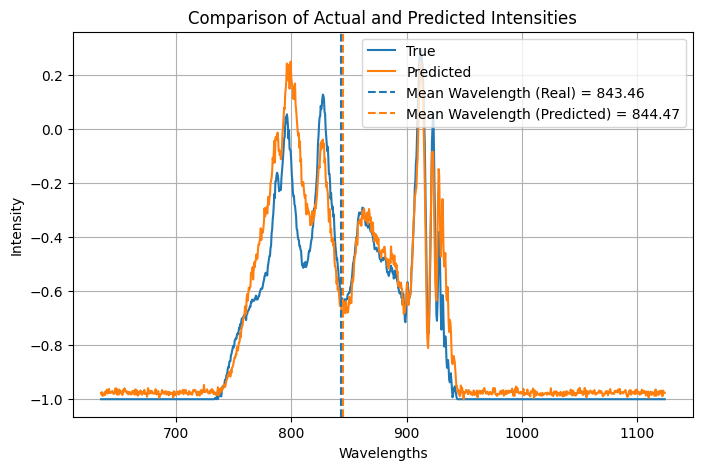

Found Optimal Parameters: [-2.86162545 -0.42290408 -2.13848031 -0.6233     -0.4695      0.
 -2.6971     -0.4462     -3.295       0.4977     22.98       51.99
  0.24      ]
Real Parameters: [-0.6233  0.1716 -0.4695 -1.2191 -1.      0.     -2.6971 -0.4462 -3.295
  0.4977 22.98   51.99    0.24  ]
Best Loss (MSE): 0.009590482235226443
Mean Wavelength (Real): 843.46
Mean Wavelength (Predicted): 844.47


In [12]:
plot_results_bayesian_optimization(best_params, 
                                   target_cond_vector, 
                                   target_intensities, 
                                   wavelengths, 
                                   optimized_indices, 
                                   fixed_indices)